## 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import fitsio
from astropy.io          import fits
import SciServer
from SciServer import Authentication, LoginPortal, Config, CasJobs, SkyQuery, SciDrive, SkyServer, Files, Jobs

from astropy.coordinates import SkyCoord
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import matplotlib
from matplotlib import cm

import healpy as hp
from tqdm.notebook import tqdm


In [2]:
def load_and_hash_specobj(filename):
    dr14 = fits.getdata(filename)
    #cutting dr14 on class
    clss = dr14["CLASS"]
    dr14 = dr14[np.where(clss == "GALAXY")]
    print("Length of dr14 after cutting on class:", len(dr14))
    #cutting data with suspicious redshifts
    dr14 = dr14[np.where((dr14['ZWARNING']==16) |
                       (dr14['ZWARNING']==0) |
                       (dr14['ZWARNING']==4))]
    print("Length of dr14 after cutting out suspicious redshifts:", len(dr14))
    #For some reason this is formatted as a string with spaces in front; remove them.
    #for i in range(len(dr14)):
    #    dr14.SPECOBJID[i]=int(dr14.SPECOBJID[i])
        
    #Format dr14 in a sorting-friendly way
    dr14ra=np.array(dr14.PLUG_RA).byteswap().newbyteorder()
    dr14dec=np.array(dr14.PLUG_DEC).byteswap().newbyteorder()
    dr14z=np.array(dr14.Z).byteswap().newbyteorder()
    dr14id=np.array(dr14.SPECOBJID)

    df=pd.DataFrame({'RA':dr14ra,'DEC':dr14dec, 'ID':dr14id, 'Z': dr14z})
    df['pixel']=hp.ang2pix(32,dr14ra,dr14dec,lonlat=True)
    
    #A fun line! Split the dr14 dataframe into N dataframes, hash_tables[i], grouped by their
    #healpix pixel
    hash_tables = [pd.DataFrame(y) for x, y in df.groupby('pixel', as_index=False)]
    
    return hash_tables

In [3]:
def correct_neighbor_zspec(neighbors, hash_tables, verbose=False):
    #Change zred to zspec for matches, and output number of changes made
    
    neighborpixel=hp.ang2pix(32,np.array(neighbors['ra']),np.array(neighbors['dec']),lonlat=True)
    
    #Search the relevant hash table for neighbor/dr14 matches
    nra,ndec,nz=[],[],[]
    hra,hdec,hz=[],[],[]
    #Match the index i of hash_tables[i] to the healpix pixel they store
    pixel_list=[]
    for i in range(len(hash_tables)):
        pixel_list=np.append(pixel_list,hash_tables[i]['pixel'].iloc[0])
    neighbors_with_zspec=0

    for i in range(len(neighbors)):
        hash_idx,=np.where(neighborpixel[i] == pixel_list)
        if (len(hash_idx)>0):
            found=0
            ht=hash_tables[hash_idx[0]]
            idx, = np.where(np.isclose(neighbors['ra'][i],np.array(ht.RA)) & np.isclose(neighbors['dec'][i],np.array(ht.DEC))) 
            if len(idx)==1:
                idx=idx[0]
                found=1
            elif len(idx)>=1:
                dist=(neighbors['ra'][i]-ht['RA'].iloc[idx])**2 + (neighbors['dec'][i]-ht['DEC'].iloc[idx])**2
                sub_idx=np.argmin(dist)
                idx=idx[sub_idx]
                found=1
            if found==1:
                neighbors_with_zspec+=1
                if (verbose==True):
                    print("neighbor RA, DEC", neighbors['ra'][i], neighbors['dec'][i])
                    print("matched dr14 RA, DEC", ht['RA'].iloc[idx], ht['DEC'].iloc[idx])
                    print("neighbor zred, specz correction",neighbors['zred'][i],ht.Z.iloc[idx])
                    print("\n")
                
                #the line that corrects zred to specz
                neighbors['zred'][i] = ht.Z.iloc[idx]
    
    return neighbors_with_zspec

In [4]:
hash_tables=load_and_hash_specobj("../rozo/specObj-dr14.fits")

Length of dr14 after cutting on class: 2779151
Length of dr14 after cutting out suspicious redshifts: 2635685


In [5]:
len(hash_tables)

3806

In [6]:
#Load the neighbors for ACT-CL J2231.9+0350
filename='neighbors.fits'
neighbors = fitsio.read(filename, header=False)
neighbors=pd.DataFrame.from_records(neighbors.tolist(), columns=neighbors.dtype.names)

with open('all_cols.npy', 'rb') as f: a = np.load(f)
a=pd.DataFrame([a.tolist()],columns=a.dtype.names)
clust=a

In [7]:
neighbors.columns

Index(['photoid', 'id', 'flagged', 'ra', 'dec', 'refmag', 'refmag_err', 'mag',
       'mag_err', 'ebv', 'zred', 'zred_e', 'zred2', 'zred2_e', 'zred_uncorr',
       'zred_uncorr_e', 'zred_samp', 'lkhd', 'chisq', 'r', 'dist',
       'zred_chisq', 'pfree', 'theta_i', 'theta_r', 'p', 'pcol', 'pmem',
       'index'],
      dtype='object')

In [8]:
ncut=neighbors[neighbors.r<3*clust.cen_err[0]]

In [9]:
# Define login Name and password before running these examples
Authentication_loginName = 'teufelsdroch';
Authentication_loginPassword = 'M4thteacher'
#logging in and getting current token from different ways

token1 = Authentication.login(Authentication_loginName, Authentication_loginPassword);
SkyServer_DataRelease = "DR16"
print("token1=" + token1)#

token1=2cf50f576b4447b195c769f73b4d7d52


In [10]:
member_ra = ncut.ra
member_dec = ncut.dec
member_z=ncut.refmag
central_ra=clust["ra"][0]
central_dec=clust["dec"][0]
central_z=clust["myz"][0]


allang=np.append( np.abs(member_ra-central_ra), np.abs(member_dec-central_dec))
theta_max_deg=1.5*np.max(allang)

Text(0, 0.5, 'DEC')

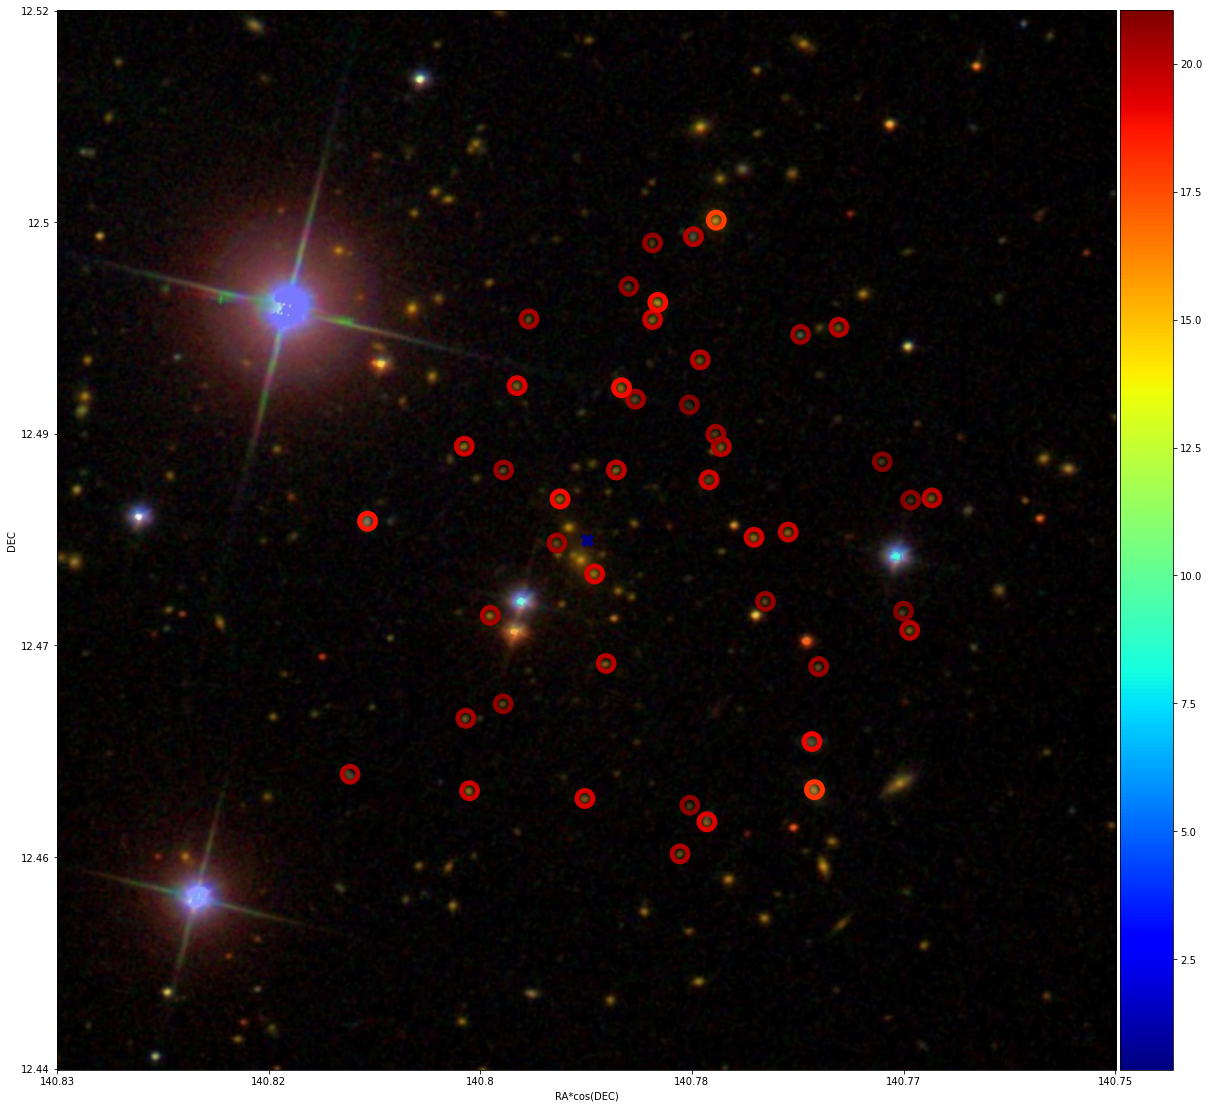

In [11]:
size=2048
arcsecperpixel= theta_max_deg*3600/size*2

img = SkyServer.getJpegImgCutout(ra=central_ra, dec=central_dec, width=size, height=size, scale=arcsecperpixel, 
                             dataRelease=SkyServer_DataRelease,
                             query="")

fig = plt.figure(figsize=(20,30))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 

ax=plt.subplot(gs[0])
ax.imshow(img)
centerradec=central_ra*np.cos(central_dec*2*np.pi/360)
memberradec=member_ra*np.cos(central_dec*2*np.pi/360)

ra_pixel=np.round( size//2+(centerradec-memberradec)*3600/arcsecperpixel )
dec_pixel=np.round( size//2+(central_dec-member_dec)*3600/arcsecperpixel )

allz=member_z
allz=np.append(allz,central_z)

my_norm = matplotlib.colors.Normalize()
my_cmap = cm.get_cmap('jet')
my_normed_data = my_norm(allz)

ec_colors = my_cmap(my_normed_data) # a Nx4 array of rgba value

cenpixra=np.round( (size//2+(central_ra-central_ra)*np.cos(central_dec*2*np.pi/360)*3600/arcsecperpixel) )
cenpixdec=np.round(size//2+(central_dec-central_dec)*3600/arcsecperpixel)

cax=ax.scatter(ra_pixel,dec_pixel, s=250, linewidths=5, color='none', edgecolors=ec_colors[0:len(member_z)])
ca1=ax.scatter(cenpixra,cenpixdec, marker='X',s=150,color=ec_colors[len(member_z)])
    
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=my_norm)
sm.set_array([])

divider = make_axes_locatable(ax)
cax2 = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(sm, cax=cax2)

meanRA=central_ra
meanDEC=central_dec

plt.sca(ax)
x_positions=np.arange(0, size, size//5)
x_labels=np.round(-((x_positions-size//2)/3600*arcsecperpixel*np.cos(meanDEC*2*np.pi/360)-meanRA*np.cos(meanDEC*2*np.pi/360)),2)
plt.xticks(x_positions, x_labels)
y_positions=np.arange(0, size, size//5)
y_labels=np.round(-((y_positions-size//2)/3600*arcsecperpixel-meanDEC),2)
plt.yticks(y_positions, y_labels)
ax.set_xlabel('RA*cos(DEC)')
ax.set_ylabel('DEC')

In [12]:
fields = "G.objID AS photoID, G.ra, G.dec, G.cmodelmag_i, G.modelmag_u, G.modelmag_g, G.modelmag_r, G.modelmag_i, G.modelmag_z, G.extinction_u,G.extinction_g,G.extinction_r,G.extinction_i,G.extinction_z,G.dered_i,G.flags"
table = "Galaxy as G"
conditions="G.ra between "+str(np.min(ncut.ra))+" and "+str(np.max(ncut.ra))
conditions=conditions+" AND G.dec between "+str(np.min(ncut.dec))+" and "+str(np.max(ncut.dec))
order="objID"

myquery = (f"SELECT {fields} "
       f"FROM {table} "
       f"WHERE {conditions} "
       f"ORDER BY {order}")

SkyServer_DataRelease = "DR16"

In [13]:
df = SkyServer.sqlSearch(sql=myquery, dataRelease=SkyServer_DataRelease)
df

,photoID,ra,dec,cmodelmag_i,modelmag_u,modelmag_g,modelmag_r,modelmag_i,modelmag_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,dered_i,flags
0,1237661070856486925,144.174063,12.473805,20.17216,23.27713,22.25032,20.64240,20.18473,19.77320,0.126841,0.098834,0.068373,0.050808,0.037792,20.13392,35253360132112
1,1237661070856486926,144.174572,12.475244,20.99963,23.96291,22.71925,21.59620,20.89290,20.05550,0.127047,0.098994,0.068484,0.050891,0.037853,20.84201,193583034532112
2,1237661070856486927,144.178781,12.480977,21.50972,25.32873,24.83357,22.58112,21.54858,20.83368,0.127543,0.099380,0.068751,0.051089,0.038001,21.49749,105622137864536
3,1237661070856486953,144.199734,12.479196,19.08804,22.02712,19.12887,17.38158,17.80386,16.72801,0.128737,0.100311,0.069395,0.051568,0.038357,17.75229,193617394536720
4,1237661070856486955,144.198689,12.478073,19.43844,24.35425,23.08883,20.87507,19.81803,19.59711,0.128728,0.100304,0.069390,0.051564,0.038354,19.76646,176025241784592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,1237661070856488126,144.201682,12.503680,21.65262,23.99633,23.92211,21.92376,21.45885,21.17975,0.127955,0.099701,0.068973,0.051254,0.038124,21.40759,281543964623104
79,1237661070856488136,144.213651,12.491359,20.74221,25.20661,24.02307,21.49888,20.79140,20.46716,0.128871,0.100415,0.069467,0.051621,0.038397,20.73978,79793623368
80,1237661070856488267,144.174346,12.468389,21.60874,25.31841,24.07401,22.87980,21.62779,21.03354,0.126296,0.098409,0.068079,0.050590,0.037630,21.57720,281543964623616
81,1237661070856488272,144.189245,12.467601,20.73116,22.81029,22.30957,21.80362,20.81146,20.07416,0.127679,0.099486,0.068824,0.051144,0.038041,20.76031,281543964754176


In [14]:
R1=4.239
R2=3.303
R3=2.285
R4=1.698
R5=1.263

In [15]:
evb=df.extinction_u/R1

In [16]:
df.modelmag_u=df.modelmag_u-df.extinction_u
df.modelmag_g=df.modelmag_g-df.extinction_g
df.modelmag_r=df.modelmag_r-df.extinction_r
df.modelmag_i=df.modelmag_i-df.extinction_i
df.modelmag_z=df.modelmag_z-df.extinction_z
df.cmodelmag_i=df.cmodelmag_i-df.extinction_i

In [17]:
member_ra = df.ra
member_dec = df.dec
member_z=df.cmodelmag_i
central_ra=clust["ra"][0]
central_dec=clust["dec"][0]
central_z=clust["myz"][0]


allang=np.append( np.abs(member_ra-central_ra), np.abs(member_dec-central_dec))
theta_max_deg=1.5*np.max(allang)

Text(0, 0.5, 'DEC')

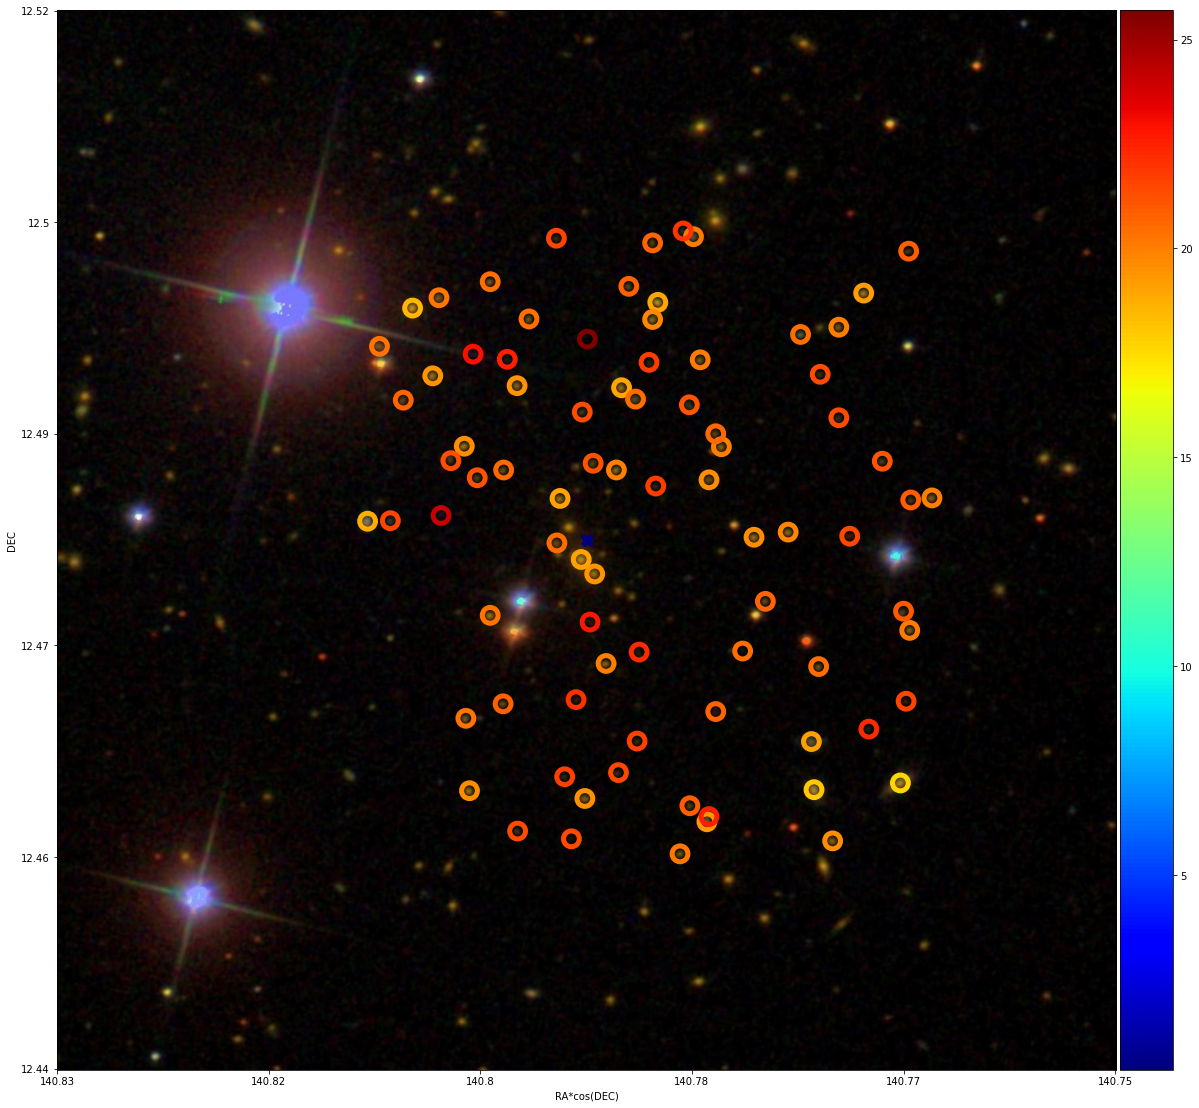

In [18]:
size=2048
arcsecperpixel= theta_max_deg*3600/size*2

img = SkyServer.getJpegImgCutout(ra=central_ra, dec=central_dec, width=size, height=size, scale=arcsecperpixel, 
                             dataRelease=SkyServer_DataRelease,
                             query="")

fig = plt.figure(figsize=(20,30))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 

ax=plt.subplot(gs[0])
ax.imshow(img)

centerradec=central_ra*np.cos(central_dec*2*np.pi/360)
memberradec=member_ra*np.cos(central_dec*2*np.pi/360)
ra_pixel=np.round( size//2+(centerradec-memberradec)*3600/arcsecperpixel )
dec_pixel=np.round( size//2+(central_dec-member_dec)*3600/arcsecperpixel )

allz=member_z
allz=np.append(allz,central_z)

my_norm = matplotlib.colors.Normalize()
my_cmap = cm.get_cmap('jet')
my_normed_data = my_norm(allz)

ec_colors = my_cmap(my_normed_data) # a Nx4 array of rgba value

cenpixra=np.round( (size//2+(central_ra-central_ra)*np.cos(central_dec*2*np.pi/360)*3600/arcsecperpixel) )
cenpixdec=np.round(size//2+(central_dec-central_dec)*3600/arcsecperpixel)

cax=ax.scatter(ra_pixel,dec_pixel, s=250, linewidths=5, color='none', edgecolors=ec_colors[0:len(member_z)])
ca1=ax.scatter(cenpixra,cenpixdec, marker='X',s=150,color=ec_colors[len(member_z)])
    
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=my_norm)
sm.set_array([])

divider = make_axes_locatable(ax)
cax2 = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(sm, cax=cax2)

meanRA=central_ra
meanDEC=central_dec

plt.sca(ax)
x_positions=np.arange(0, size, size//5)
x_labels=np.round(-((x_positions-size//2)/3600*arcsecperpixel*np.cos(meanDEC*2*np.pi/360)-meanRA*np.cos(meanDEC*2*np.pi/360)),2)
plt.xticks(x_positions, x_labels)
y_positions=np.arange(0, size, size//5)
y_labels=np.round(-((y_positions-size//2)/3600*arcsecperpixel-meanDEC),2)
plt.yticks(y_positions, y_labels)
ax.set_xlabel('RA*cos(DEC)')
ax.set_ylabel('DEC')

In [19]:
df.at[1,'modelmag_u']

23.8358633

In [20]:
for i in range(len(ncut)):
    idx, = np.where(np.isclose(ncut['ra'][i],np.array(df.ra)) & np.isclose(ncut['dec'][i],np.array(df.dec)))
    if len(idx)>0: idx=idx[0]
    else: continue
    newmag=[df.at[idx,'modelmag_u'],df.at[idx,'modelmag_g'], df.at[idx,'modelmag_r'], df.at[idx,'modelmag_i'], df.at[idx,'modelmag_z']]
    print('old mags ', ncut['mag'][i])
    print('new mags ', newmag)
    print('old refmag', ncut['refmag'][i])
    print('new refmag ', df.at[idx,'cmodelmag_i'])

old mags  [24.227585 22.821398 21.264282 20.534697 20.084389]
new mags  [24.149076100000002, 22.836422499999998, 21.27563004, 20.55123353, 20.10645914]
old refmag 20.4515438079834
new refmag  20.46810353
old mags  [24.314121 22.974724 20.794193 19.749832 19.536163]
new mags  [24.2255218, 22.988525900000003, 20.80568006, 19.76646584, 19.55875573]
old refmag 19.370227813720703
new refmag  19.38687584
old mags  [24.827534 21.658274 19.875202 19.30859  19.420164]
new mags  [24.6731668, 21.6774399, 19.887081260000002, 19.325753889999998, 19.441724039999997]
old refmag 18.990741729736328
new refmag  19.007913889999998
old mags  [23.653807 22.40414  20.558996 19.945248 19.627962]
new mags  [23.629953999999998, 22.42222142, 20.57070145, 19.96244292, 19.647782579999998]
old refmag 19.976287841796875
new refmag  19.99347292
old mags  [24.854506 22.753332 21.167389 20.699219 20.210915]
new mags  [24.697484399999997, 22.7698545, 21.17898529, 20.71631486, 20.230107580000002]
old refmag 20.572216033

In [21]:
ncut['mag'][0]

array([24.227585, 22.821398, 21.264282, 20.534697, 20.084389],
      dtype=float32)

In [22]:
nchanges=correct_neighbor_zspec(neighbors, hash_tables, verbose=True)

neighbor RA, DEC 144.18920314876857 12.505068671538899
matched dr14 RA, DEC 144.18921 12.505088
neighbor zred, specz correction 0.3104379177093506 0.31043792


neighbor RA, DEC 144.18077520877205 12.45582877749781
matched dr14 RA, DEC 144.18078000000003 12.455829
neighbor zred, specz correction 0.33163776993751526 0.33163777


neighbor RA, DEC 144.2697586802565 12.479426747955038
matched dr14 RA, DEC 144.26978 12.479445
neighbor zred, specz correction 0.14101707935333252 0.14101708


neighbor RA, DEC 144.13282490746772 12.4539274376085
matched dr14 RA, DEC 144.13283 12.453944
neighbor zred, specz correction 0.3354693353176117 0.33546934


neighbor RA, DEC 144.1895734633078 12.562671472740996
matched dr14 RA, DEC 144.18957 12.562671
neighbor zred, specz correction 0.3297593295574188 0.32975933


neighbor RA, DEC 144.2523764452867 12.557132709904245
matched dr14 RA, DEC 144.25238000000002 12.557133
neighbor zred, specz correction 0.32894769310951233 0.3289477


neighbor RA, DEC 144.10143

<ipython-input-3-9c49a215a4eb>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbors['zred'][i] = ht.Z.iloc[idx]


In [23]:
#planning to replace galaxy catalog

In [24]:
filename = '/home/mr.bwolfe/myredmapper/pixelized_dr8_v10/dr8_galaxies_clean_v10_master_table.fit'

In [25]:
master = fitsio.read(filename, header=False)
master=pd.DataFrame.from_records(master.tolist(), columns=master.dtype.names)
master

,nside,hpix,ra_pix,dec_pix,ngals,filenames,lim_ref,ref_ind,area,nmag,mode,b,zeropoint,u_ind,g_ind,r_ind,i_ind,z_ind
0,32,"[391, 392, 393, 394, 443, 447, 448, 449, 450, ...","[176.78571428571428, 183.2142857142857, 189.64...","[69.4225464945822, 69.4225464945822, 69.422546...","[937, 2498, 2077, 362, 4461, 3885, 11436, 1454...","[dr8_galaxies_clean_v10_0000391.fit , dr8_ga...",21.2911,3,10401.5,5,SDSS,"[1.4e-10, 9e-11, 1.2e-10, 1.8e-10, 7.4e-10]",22.5,0,1,2,3,4


In [26]:
coords = hp.boundaries(nside=32, pix=2632, nest=False)
ra, dec = hp.vec2ang(np.transpose(coords), lonlat=True)
radec = SkyCoord(ra, dec, unit='deg', frame='icrs')

<ipython-input-26-42a25a62fa6d>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=2632, nest=False)
<ipython-input-26-42a25a62fa6d>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coord

In [27]:
filename = '/home/mr.bwolfe/myredmapper/pixelized_dr8_v10/dr8_galaxies_clean_v10_0002632.fit'

In [28]:
example = fitsio.read(filename, header=False)
example=pd.DataFrame.from_records(example.tolist(), columns=example.dtype.names)
example

,photoid,id,flagged,ra,dec,refmag,refmag_err,mag,mag_err,ebv
0,48290301101691026,35761569,0,21.750325,34.044525,18.981375,0.019890,"[23.13508, 21.082, 19.573324, 19.008894, 18.75...","[0.6113571, 0.053089134, 0.021260686, 0.019899...",0.050895
1,48290301101691027,35761570,0,21.748616,34.041502,20.187418,0.053552,"[23.2246, 21.738554, 20.900179, 20.3597, 20.35...","[0.5862305, 0.08201219, 0.055314578, 0.0538721...",0.050818
2,48290301101691054,35761576,0,21.804521,34.041606,20.928522,0.101299,"[25.28862, 22.194155, 21.416677, 21.007795, 20...","[1.0196488, 0.13178232, 0.094001204, 0.1037008...",0.050255
3,48290301101691020,35761568,0,21.838866,34.028107,19.089914,0.018005,"[22.587112, 20.89056, 19.571522, 19.081337, 18...","[0.32241145, 0.037955962, 0.018346287, 0.01800...",0.049190
4,48290301101691037,35761571,0,21.791797,34.036863,21.008196,0.076300,"[22.968586, 21.731438, 21.039562, 20.914867, 2...","[0.42606586, 0.07231844, 0.055754285, 0.077557...",0.050442
...,...,...,...,...,...,...,...,...,...,...
15608,77810301600760070,51748907,0,22.205154,34.802369,17.816225,0.011040,"[21.18557, 19.483482, 18.378347, 17.86267, 17....","[0.21308802, 0.017292803, 0.011488633, 0.01104...",0.048532
15609,77810301600760069,51748906,4,22.210974,34.807195,17.058174,0.007627,"[21.00247, 18.714611, 17.635605, 17.14465, 16....","[0.21496905, 0.011538675, 0.007877718, 0.00763...",0.048491
15610,77810301600760373,51748932,0,22.239230,34.803194,20.907850,0.253666,"[24.711128, 21.859976, 21.15085, 20.94213, 20....","[1.5486895, 0.07765073, 0.072315544, 0.0925999...",0.048848
15611,77810301400790487,51711673,0,22.540372,33.890691,20.213375,0.138543,"[22.080315, 21.461767, 21.24809, 20.749125, 20...","[0.4210454, 0.076873235, 0.11747029, 0.1089105...",0.044733


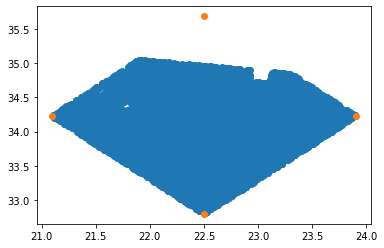

In [29]:
plt.scatter(example.ra,example.dec)
plt.scatter(radec.ra.degree,radec.dec.degree)

In [30]:
fields = "G.objID AS photoID, G.ra, G.dec, G.cmodelmag_i, G.modelmag_u, G.modelmag_g, G.modelmag_r, G.modelmag_i, G.modelmag_z, G.extinction_u,G.clean,G.cmodelmagerr_i,G.modelmagerr_u, G.modelmagerr_g, G.modelmagerr_r, G.modelmagerr_i, G.modelmagerr_z"
table = "Galaxy as G"
conditions="G.ra between "+str(np.min(radec.ra.degree)-0.1)+" and "+str(np.max(radec.ra.degree)+0.1)
conditions=conditions+" AND G.dec between "+str(np.min(radec.dec.degree)-0.1)+" and "+str(np.max(radec.dec.degree)+0.1)
order="objID"

myquery = (f"SELECT {fields} "
       f"FROM {table} "
       f"WHERE {conditions} "
       f"ORDER BY {order}")

SkyServer_DataRelease = "DR16"

In [31]:
conditions

'G.ra between 20.993749999999995 and 24.00625 AND G.dec between 32.697168295823644 and 35.78533471265205'

In [32]:
%%time
df = SkyServer.sqlSearch(sql=myquery, dataRelease=SkyServer_DataRelease)
df

CPU times: user 592 ms, sys: 79.2 ms, total: 671 ms
Wall time: 8.78 s


,photoID,ra,dec,cmodelmag_i,modelmag_u,modelmag_g,modelmag_r,modelmag_i,modelmag_z,extinction_u,clean,cmodelmagerr_i,modelmagerr_u,modelmagerr_g,modelmagerr_r,modelmagerr_i,modelmagerr_z
0,1237666213541183569,21.433414,32.703805,18.99841,24.35913,25.11438,24.80203,23.97310,19.97281,0.219861,0,0.316248,1.072954,0.547815,0.630539,0.613061,0.115091
1,1237666213541183571,21.436314,32.702756,21.98403,24.83619,25.30814,24.81464,22.38564,22.32910,0.220055,0,0.188508,0.600945,0.480077,0.568710,0.191551,0.566778
2,1237666213541183573,21.435572,32.703810,22.66541,23.65937,25.02548,23.57173,22.85353,23.52063,0.219986,0,0.526336,0.457348,0.493528,0.340616,0.281622,0.511350
3,1237666213541183578,21.536962,32.697724,21.80899,24.43955,24.20581,22.32154,21.90212,21.72998,0.225514,0,0.389383,0.783000,0.451270,0.149145,0.157710,0.498614
4,1237666213541183598,21.585345,32.709010,20.69954,24.63467,24.06181,21.58470,20.76872,22.46572,0.226146,1,0.070464,0.808716,0.450367,0.082346,0.060311,0.756862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86797,1237678894964147504,23.978062,34.554267,21.56803,22.20238,24.31770,22.47727,23.08697,22.82505,0.153568,0,0.963445,0.308746,0.488137,0.234580,0.610461,0.939240
86798,1237678894964147505,23.955224,34.396630,22.33270,22.69481,23.22317,22.06523,22.39341,23.28957,0.157254,0,0.524455,0.572998,0.282251,0.201031,0.420743,1.081231
86799,1237678894964147510,23.962401,34.419875,21.52426,25.88148,23.53120,23.46005,21.52412,21.72017,0.159083,0,0.240807,0.970459,0.352054,0.645724,0.190255,0.728683
86800,1237678894964147511,23.958631,34.398811,20.95625,26.89094,22.93448,22.60456,20.91589,21.14124,0.157205,0,0.297645,0.783669,0.406740,0.642949,0.220843,0.962994


In [33]:
from SciServer import CasJobs

In [34]:
%%time

bigtablename = 'hugetable'

hugequery = (f"SELECT {fields} INTO mydb.hugetable "
       f"FROM {table} "
       f"WHERE {conditions} "
       f"ORDER BY {order}")

print('Submitting query:\n',hugequery)
print('\n')

thisjobid = CasJobs.submitJob(sql=hugequery, context="DR16")

print('Job submitted with jobId = ',thisjobid)
print('\n')

waited = CasJobs.waitForJob(jobId=thisjobid)      # waited is a dummy variable; just print wait msg
jobDescription = CasJobs.getJobStatus(thisjobid)

print('\n')
print('Information about the job:')

df = CasJobs.executeQuery(sql='SELECT * FROM hugetable', context="MyDB")
CasJobs.executeQuery(sql='DROP TABLE hugetable', context="MyDB")


Submitting query:
 SELECT G.objID AS photoID, G.ra, G.dec, G.cmodelmag_i, G.modelmag_u, G.modelmag_g, G.modelmag_r, G.modelmag_i, G.modelmag_z, G.extinction_u,G.clean,G.cmodelmagerr_i,G.modelmagerr_u, G.modelmagerr_g, G.modelmagerr_r, G.modelmagerr_i, G.modelmagerr_z INTO mydb.hugetable FROM Galaxy as G WHERE G.ra between 20.993749999999995 and 24.00625 AND G.dec between 32.697168295823644 and 35.78533471265205 ORDER BY objID


Job submitted with jobId =  51615201




Information about the job:
CPU times: user 773 ms, sys: 174 ms, total: 947 ms
Wall time: 33.5 s


,Rows Affected
0,0


In [35]:
df

,photoID,ra,dec,cmodelmag_i,modelmag_u,modelmag_g,modelmag_r,modelmag_i,modelmag_z,extinction_u,clean,cmodelmagerr_i,modelmagerr_u,modelmagerr_g,modelmagerr_r,modelmagerr_i,modelmagerr_z
0,1237666213541183569,21.433414,32.703805,18.99841,24.35913,25.11438,24.80203,23.97310,19.97281,0.219861,0,0.316248,1.072954,0.547815,0.630539,0.613061,0.115091
1,1237666213541183571,21.436314,32.702756,21.98403,24.83619,25.30814,24.81464,22.38564,22.32910,0.220055,0,0.188508,0.600945,0.480077,0.568710,0.191551,0.566778
2,1237666213541183573,21.435572,32.703810,22.66541,23.65937,25.02548,23.57173,22.85353,23.52063,0.219986,0,0.526336,0.457348,0.493528,0.340616,0.281622,0.511350
3,1237666213541183578,21.536962,32.697724,21.80899,24.43955,24.20581,22.32154,21.90212,21.72998,0.225514,0,0.389383,0.783000,0.451270,0.149145,0.157710,0.498614
4,1237666213541183598,21.585345,32.709010,20.69954,24.63467,24.06181,21.58470,20.76872,22.46572,0.226146,1,0.070464,0.808716,0.450367,0.082346,0.060311,0.756862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86797,1237678894964147504,23.978062,34.554267,21.56803,22.20238,24.31770,22.47727,23.08697,22.82505,0.153568,0,0.963445,0.308746,0.488137,0.234580,0.610461,0.939240
86798,1237678894964147505,23.955224,34.396630,22.33270,22.69481,23.22317,22.06523,22.39341,23.28957,0.157254,0,0.524455,0.572998,0.282251,0.201031,0.420743,1.081231
86799,1237678894964147510,23.962401,34.419875,21.52426,25.88148,23.53120,23.46005,21.52412,21.72017,0.159083,0,0.240807,0.970459,0.352054,0.645724,0.190255,0.728683
86800,1237678894964147511,23.958631,34.398811,20.95625,26.89094,22.93448,22.60456,20.91589,21.14124,0.157205,0,0.297645,0.783669,0.406740,0.642949,0.220843,0.962994


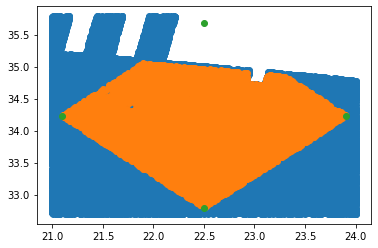

In [36]:
plt.scatter(df.ra,df.dec)
plt.scatter(example.ra,example.dec)
plt.scatter(radec.ra.degree,radec.dec.degree)

In [37]:
#Which pixel should this galaxy be in?
df['pixel']=hp.ang2pix(32,np.array(df.ra),np.array(df.dec),lonlat=True)

In [38]:
df2=df[df['pixel']==2632]

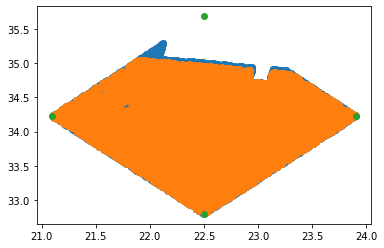

In [39]:
plt.scatter(df2.ra,df2.dec)
plt.scatter(example.ra,example.dec)
plt.scatter(radec.ra.degree,radec.dec.degree)

In [40]:
pixels=master.hpix[0]

In [45]:
pixels[3152]

6453

In [48]:
925+821

1746

In [46]:
for i in tqdm(range(3152,len(pixels))):
#for i in range(1):
    coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
    ra, dec = hp.vec2ang(np.transpose(coords), lonlat=True)
    radec = SkyCoord(ra, dec, unit='deg', frame='icrs')

    fields = "G.objID AS photoID, G.ra, G.dec, G.cmodelmag_i, G.modelmag_u, G.modelmag_g, G.modelmag_r, G.modelmag_i, G.modelmag_z, G.extinction_u,G.clean,G.cmodelmagerr_i,G.modelmagerr_u, G.modelmagerr_g, G.modelmagerr_r, G.modelmagerr_i, G.modelmagerr_z"
    table = "Galaxy as G"
    conditions="G.ra between "+str(np.min(radec.ra.degree)-0.1)+" and "+str(np.max(radec.ra.degree)+0.1)
    conditions=conditions+" AND G.dec between "+str(np.min(radec.dec.degree)-0.1)+" and "+str(np.max(radec.dec.degree)+0.1)
    order="objID"

    myquery = (f"SELECT {fields} "
           f"FROM {table} "
           f"WHERE {conditions} "
           f"ORDER BY {order}")

    df = SkyServer.sqlSearch(sql=myquery, dataRelease=SkyServer_DataRelease)
    #Which pixel should this galaxy be in?
    df['pixel']=hp.ang2pix(32,np.array(df.ra),np.array(df.dec),lonlat=True)

    df2=df[df['pixel']==pixels[i]]

    fn='./pixelized_cat_pkl/cat'+str(pixels[i])+'.pkl'
    df2.to_pickle(fn)

  0%|          | 0/280 [00:00<?, ?it/s]

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coords = hp.boundaries(nside=32, pix=pixels[i], nest=False)
<ipython-input-46-4a323f71c314>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

In [228]:
len(pixels)*5

17160

In [246]:
filename = '/home/mr.bwolfe/myredmapper/pixelized_dr8_v10/dr8_galaxies_clean_v10_0000391.fit'
example = fitsio.read(filename, header=False)
example=pd.DataFrame.from_records(example.tolist(), columns=example.dtype.names)

In [247]:
df2=pd.read_pickle('./pixelized_cat_pkl/cat391.pkl')
df2

,photoID,ra,dec,cmodelmag_i,modelmag_u,modelmag_g,modelmag_r,modelmag_i,modelmag_z,extinction_u,clean,pixel
2140,1237651274046242850,174.012534,68.063194,14.28234,23.41419,15.28278,15.34133,14.28855,25.73594,0.035784,0,391
2141,1237651274046242852,173.998181,68.065237,19.83934,23.98670,22.13272,20.39374,19.85117,19.16328,0.035795,0,391
2142,1237651274046242857,174.017521,68.071907,21.39781,24.58252,23.80814,22.24848,21.52618,22.87533,0.035637,1,391
2143,1237651274046242872,174.067838,68.191575,20.92455,24.40649,23.05415,21.53417,21.00010,21.40970,0.039908,1,391
2155,1237651274046242965,174.051092,68.111524,21.32714,24.34479,23.76479,21.09072,20.88309,21.54199,0.035128,0,391
...,...,...,...,...,...,...,...,...,...,...,...,...
82779,1237671751899677274,179.994423,70.489035,21.66397,26.62594,23.92552,22.14718,21.40503,21.54934,0.069826,1,391
82785,1237671751899677305,179.991839,70.462643,21.66144,23.76384,23.43561,21.70806,21.35216,20.29374,0.071305,1,391
82797,1237671751899677387,179.934640,70.545384,20.54654,22.48988,23.47581,21.67796,20.54421,20.35927,0.069842,0,391
82799,1237671751899677414,179.997044,70.486132,21.55168,25.29015,25.12737,22.55082,21.55177,20.96700,0.069887,0,391


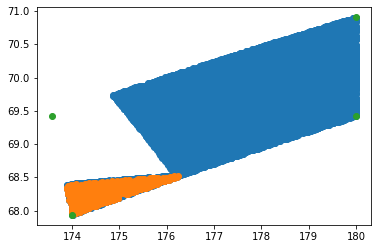

In [248]:
plt.scatter(df2.ra,df2.dec)
plt.scatter(example.ra,example.dec)
plt.scatter(radec.ra.degree,radec.dec.degree)